# **Laboratorio 5 ModSim**
- Joaquín Campos - 22155
- Sofía García - 22210
- Julio García Salas - 22076

## **Práctica**

In [ ]:
# !pip install networkx matplotlib numpy pandas


In [ ]:
# Redes Scale-Free (BA) vs Aleatoria (ER)

import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def degrees_array(G: nx.Graph):
    return np.array([d for _, d in G.degree()], dtype=float)

def gini_coefficient(x: np.ndarray) -> float:
    """Gini (0 = igualdad perfecta, 1 = desigualdad máxima)."""
    if len(x) == 0:
        return float('nan')
    x = np.sort(x)
    if np.all(x == 0):
        return 0.0
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * (cumx.sum() / cumx[-1])) / n

def ccdf(values: np.ndarray):
    """CCDF P(X >= x) para valores no negativos. Retorna (xs, ccdf_vals)."""
    vals = np.asarray(values)
    vals = vals[vals >= 0]
    xs = np.unique(vals)
    ccdf_vals = np.array([np.mean(vals >= x) for x in xs], dtype=float)
    return xs, ccdf_vals

def giant_component_subgraph(G: nx.Graph) -> nx.Graph:
    """Extrae el subgrafo de la componente conexa gigante (GCC)."""
    if G.number_of_nodes() == 0:
        return G.copy()
    comps = list(nx.connected_components(G))
    largest = max(comps, key=len) if comps else set()
    return G.subgraph(largest).copy()


In [9]:
n = 1000
m_ba = 3                      
target_avg_k = 2 * m_ba       
p_er = target_avg_k / (n - 1) 

print(f"Parámetros:\n  n = {n}\n  BA: m = {m_ba} → ⟨k⟩ esperado ≈ {2*m_ba}\n  ER: p ≈ {p_er:.6f}")

G_ba = nx.barabasi_albert_graph(n=n, m=m_ba, seed=SEED)
G_er = nx.erdos_renyi_graph(n=n, p=p_er, seed=SEED)

avg_ba = np.mean(degrees_array(G_ba))
avg_er = np.mean(degrees_array(G_er))
print(f"Grado promedio empírico → BA: {avg_ba:.3f} | ER: {avg_er:.3f}")


Parámetros:
  n = 1000
  BA: m = 3 → ⟨k⟩ esperado ≈ 6
  ER: p ≈ 0.006006
Grado promedio empírico → BA: 5.982 | ER: 6.038


In [10]:
def compute_metrics(G: nx.Graph, name: str):
    degs = degrees_array(G)
    avg_k = degs.mean() if len(degs) else float('nan')
    num_comp = nx.number_connected_components(G)
    gcc = giant_component_subgraph(G)
    n_gcc = gcc.number_of_nodes()

    # Clustering
    trans = nx.transitivity(G) if G.number_of_nodes() > 1 else float('nan')
    avg_clust = nx.average_clustering(G) if G.number_of_nodes() > 1 else float('nan')

    # Distancias en la GCC (ER puede estar desconectada)
    try:
        aspl = nx.average_shortest_path_length(gcc) if n_gcc > 1 else float('nan')
    except Exception:
        aspl = float('nan')
    try:
        diam = nx.diameter(gcc) if n_gcc > 1 else float('nan')
    except Exception:
        diam = float('nan')

    # Asortatividad por grado
    try:
        assort = nx.degree_assortativity_coefficient(G)
    except Exception:
        assort = float('nan')

    # Desigualdad de grados
    gini = gini_coefficient(degs)

    return {
        "Red": name,
        "n": G.number_of_nodes(),
        "m (aristas)": G.number_of_edges(),
        "k̄ (grado promedio)": avg_k,
        "Componentes": num_comp,
        "Tamaño GCC": n_gcc,
        "Transitividad (global C)": trans,
        "Clustering promedio": avg_clust,
        "ASPL (GCC)": aspl,
        "Diámetro (GCC)": diam,
        "Asortatividad (grado)": assort,
        "Gini del grado": gini,
    }

metrics_ba = compute_metrics(G_ba, "Barabási–Albert (BA)")
metrics_er = compute_metrics(G_er, "Erdős–Rényi (ER)")

df_metrics = pd.DataFrame([metrics_ba, metrics_er])
df_metrics.round(4)


,Red,n,m (aristas),k̄ (grado promedio),Componentes,Tamaño GCC,Transitividad (global C),Clustering promedio,ASPL (GCC),Diámetro (GCC),Asortatividad (grado),Gini del grado
0,Barabási–Albert (BA),1000,2991,5.982,1,1000,0.0175,0.0333,3.4665,6,-0.0757,0.3724
1,Erdős–Rényi (ER),1000,3019,6.038,6,995,0.0079,0.0091,4.0337,7,-0.0013,0.2292


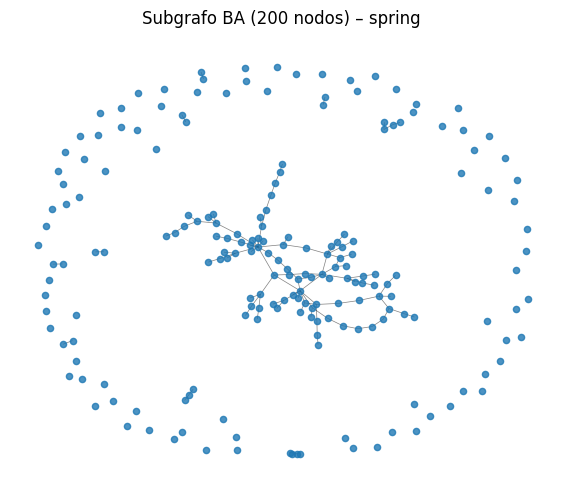

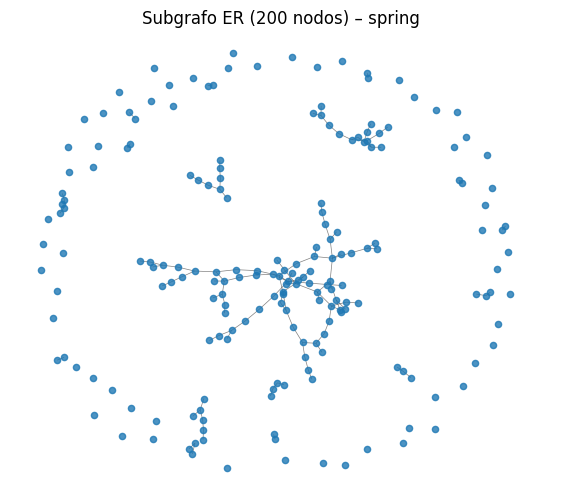

In [11]:
def sample_induced(G: nx.Graph, k: int, seed: int = 1) -> nx.Graph:
    rng = np.random.default_rng(seed)
    nodes = np.array(G.nodes())
    if len(nodes) <= k:
        return G.copy()
    picked = rng.choice(nodes, size=k, replace=False)
    return G.subgraph(picked).copy()

k_sample = 200
G_ba_s = sample_induced(G_ba, k_sample, seed=SEED)
G_er_s = sample_induced(G_er, k_sample, seed=SEED)

# BA (subgrafo)
plt.figure(figsize=(7, 6))
pos_ba = nx.spring_layout(G_ba_s, seed=SEED)
nx.draw_networkx_nodes(G_ba_s, pos_ba, node_size=20, alpha=0.8)
nx.draw_networkx_edges(G_ba_s, pos_ba, width=0.5, alpha=0.5)
plt.title("Subgrafo BA (200 nodos) – spring")
plt.axis('off')
plt.show()

# ER (subgrafo)
plt.figure(figsize=(7, 6))
pos_er = nx.spring_layout(G_er_s, seed=SEED)
nx.draw_networkx_nodes(G_er_s, pos_er, node_size=20, alpha=0.8)
nx.draw_networkx_edges(G_er_s, pos_er, width=0.5, alpha=0.5)
plt.title("Subgrafo ER (200 nodos) – spring")
plt.axis('off')
plt.show()


## **Teoría**

# Redes libres de escala vs. redes aleatorias 

## 1) Rasgo definitorio y por qué obliga a ir más allá del promedio

La característica más definitoria de una red libre de escala es que su **distribución de grados** sigue una **ley de potencia**:
  
- $$P(k) \propto k^{-\gamma}, \quad k \ge k_{\min}$$

En contraste, una red Erdős–Rényi (ER) tiene una distribución de grados **(aprox.) Poisson**, estrecha alrededor de la media:

- $$P(k) \approx \frac{e^{-\langle k\rangle}\langle k\rangle^{k}}{k!}$$

**Implicación clave:** en redes libres de escala aparece **heterogeneidad extrema** (hubs). Por eso, los modelos basados **sólo en promedios** (p. ej., SIR “mean-field” clásico que usa únicamente $\langle k\rangle$) **no capturan** la dinámica real. En estas redes, los **momentos superiores** importan (especialmente $\langle k^2\rangle$). De hecho, para $2<\gamma\le 3$ la **varianza** $\mathrm{Var}(k)$ puede crecer sin cota con el tamaño de la red, cambiando el **umbral epidémico** y la **intensidad de brotes**. En resumen: debo modelar la **heterogeneidad de grados**, no sólo el promedio.

---

## 2) Efecto de un $\gamma$ menor (p. ej., $2.1$ vs $3.5$)

Un $\gamma$ menor implica una **cola más pesada**:

- **Mayor prevalencia de hubs** (nodos con grado muy alto).
- $\langle k^2\rangle$ crece mucho; para $2<\gamma\le 3$, incluso **puede divergir** con $N$.
- En la práctica: con $\gamma=2.1$ espero **muchos** nodos altamente conectados; con $\gamma=3.5$ la cola decae más rápido y los hubs extremos son más raros.

---

## 3) Por qué $R_0$ depende de la **varianza** (no sólo de la media)

En redes con heterogeneidad de grados (p. ej., configuration model), el número reproductivo básico está controlado por la razón entre el **segundo momento** y el **primero**:

- $$R_0 \;\approx\; T \cdot \frac{\langle k^2\rangle - \langle k\rangle}{\langle k\rangle} \quad\Longleftrightarrow\quad \lambda_c \;=\; \frac{\langle k\rangle}{\langle k^2\rangle}$$

donde $T$ es la transmisibilidad por arista y $\lambda_c$ el **umbral epidémico** efectivo.

**Intuición:** la infección “ve” grados altos porque llega por aristas; la probabilidad de aterrizar en un nodo de grado $k$ es $\propto k\,P(k)$. Esa ponderación **eleva** el peso de nodos con grados grandes, introduciendo $\langle k^2\rangle$ y, por ende, la **varianza**. Si $\langle k^2\rangle$ es grande (o diverge), $R_0$ **aumenta** y el umbral $\lambda_c$ **tiende a 0**: casi cualquier transmisibilidad sostiene brotes.

---

## 4) Intervenciones **dirigidas** en redes sin escala: por qué son tan eficaces

### (a) Perspectiva matemática

- El umbral epidémico depende de $$\lambda_c = \frac{\langle k\rangle}{\langle k^2\rangle}.$$
- **Proteger/remover hubs** (vacunar, testear, mascarillas focalizadas, limitar contactos) **reduce drásticamente $\langle k^2\rangle$** (mucho más que $\langle k\rangle$), **elevando $\lambda_c$** y pudiendo volver la propagación **subcrítica** sin intervenir masivamente.
- En ER (distribución estrecha), “apuntar” a grados altos es **casi equivalente a aleatorio** (no hay outliers grandes), por lo que la ganancia marginal es menor.

### (b) Perspectiva práctica

- En redes sin escala, **pocos hubs concentran muchas rutas** de transmisión. Focalizar recursos en esos centros:
  - **Corta** múltiples trayectorias de contagio de una sola vez.
  - Es **eficiente** en costos (menos individuos intervenidos para gran impacto).
- En redes ER no existen cuellos de botella comparables; el mismo esfuerzo **difuso** rinde menos.
